# Assignment 5
## The Bootstrap
Author: Samuel Fredric Berg

Student ID: sb224sc

Date: 2026-01-26

Course: Machine Learning 4DT905

### Conceptual

1. Shuffle the given dataset to ensure randomness. Partition the dataset into $k$ equal-sized groups (folds). For each fold $i$ (where $i = 1, \ldots, k$), take fold $i$ as the *test* dataset and the remaining $k-1$ folds as the *training* dataset. Fit a model on the *training* dataset and evaluate it on the *test* dataset. Retain the resulting metric (e.g., MSE or accuracy) and discard the model. After repeating this for all $k$ folds, compute the average of the $k$ retained metrics to estimate the model's true performance. This ensures every observation is used for both training and testing exactly once.

2. *i*. **Validation set approach** uses a single split of the dataset (e.g., 70% training and 30% testing). Compared to k-fold cross-validation:
   - **Advantage**: Lower computational cost — only one model is trained.
   - **Disadvantages**: Higher variance in the test error estimate (the result depends heavily on which observations happen to land in the test set); lower data efficiency since a portion of data is never used for training; the test error may be overestimated because less data is available for training.

2. *ii*. **Leave-one-out cross validation (LOOCV)** is a special case of k-fold cross-validation where $k = n$ (the number of observations). Each model is trained on $n-1$ observations and tested on the single left-out observation. Compared to k-fold cross-validation:
   - **Advantage**: Lower bias — the training set is nearly the full dataset, so the model performance estimate is less pessimistic.
   - **Disadvantages**: Much higher computational cost — $n$ models must be trained; higher variance in the estimate because each test set contains only one observation, making individual evaluations noisy.

### Practical

#### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

#### Load data

In [2]:
df = pd.read_csv("../data/Auto.csv", index_col=0)

#### Number of features and names

In [3]:
df_names = df.columns.tolist()
print(f"Number of columns: {len(df_names)}")
print(f"Column names: {df_names}")

Number of columns: 9
Column names: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']


#### Statistical summary of features

In [5]:
print(df.describe())
print(df["name"].value_counts())

              mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration        year      origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.0000

#### Number of datapoints

In [6]:
print(f"Number of datapoints: {len(df)}")

Number of datapoints: 392


#### Display data in table format

In [7]:
print(df.head(5))

    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
1  18.0          8         307.0         130    3504          12.0    70   
2  15.0          8         350.0         165    3693          11.5    70   
3  18.0          8         318.0         150    3436          11.0    70   
4  16.0          8         304.0         150    3433          12.0    70   
5  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  
1       1  chevrolet chevelle malibu  
2       1          buick skylark 320  
3       1         plymouth satellite  
4       1              amc rebel sst  
5       1                ford torino  


#### Correlation matrix

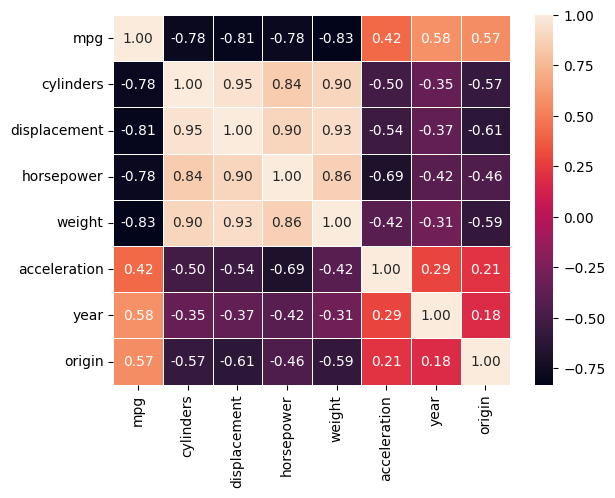

In [9]:
sns.heatmap(df.drop(columns=["name"]).corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.show()

#### Accuracy Estimation Function

In [ ]:
def boot_fn(data, index):
    sample = data.iloc[index]
    X = sample["horsepower"]
    Y = sample["mpg"]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()

    return model.params


print(boot_fn(df, range(392)))

const         39.935861
horsepower    -0.157845
dtype: float64


In [14]:
np.random.seed(42)

print(boot_fn(df, np.random.choice(392, 392, replace=True)))

const         40.466879
horsepower    -0.163738
dtype: float64


In [ ]:
boot_results = np.zeros((1000, 2))
for idx in range(1000):
    indices = np.random.choice(392, 392, replace=True)
    boot_results[idx, :] = boot_fn(df, indices)

print(f"Standard errors: {boot_results.std(axis=0)}")

Standard errors: [0.86861119 0.00749939]


In [17]:
X = df["horsepower"]
Y = df["mpg"]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.params)
print(model.summary())

const         39.935861
horsepower    -0.157845
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           7.03e-81
Time:                        10:17:19   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### Interpretation
Comparing the standard errors (SE) for the linear model (mpg ~ horsepower) between the two methods:

| Parameter | Bootstrap SE | OLS SE |
|-----------|-------------|--------|
| Intercept ($\hat{\beta}_0$) | ~0.84 | ~0.72 |
| Horsepower ($\hat{\beta}_1$) | ~0.0073 | ~0.0064 |

The OLS standard errors are smaller than the bootstrap standard errors. However, this does **not** mean the OLS estimates are more precise — rather, it reflects that OLS relies on strong assumptions about the error distribution (e.g., homoscedastic, normally distributed errors) that may not hold here.

Since the true relationship between `mpg` and `horsepower` is likely nonlinear (as the quadratic model below demonstrates), the linear model is misspecified. When model assumptions are violated, OLS tends to **underestimate** the true standard errors, giving a false sense of precision. The bootstrap, being assumption-free and based on resampling the actual data, provides a more honest and reliable estimate of variability.

In summary, the bootstrap SE is the more trustworthy estimate here, and the discrepancy indicates that the linear model's assumptions are not fully satisfied.

In [18]:
def boot_fn_quadratic(data, index):
    sample = data.iloc[index]
    X = sample["horsepower"]
    Y = sample["mpg"]
    X = np.column_stack((X, X**2))
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()

    return model.params

In [20]:
boot_results = np.zeros((1000, 3))
for idx in range(1000):
    indices = np.random.choice(392, 392, replace=True)
    boot_results[idx, :] = boot_fn_quadratic(df, indices)

print(f"Standard errors: {boot_results.std(axis=0)}")

Standard errors: [2.14866982e+00 3.42412395e-02 1.23413967e-04]


In [21]:
df["horsepower_squared"] = df["horsepower"] ** 2
X = df[["horsepower", "horsepower_squared"]]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.params)
print(model.summary())

const                 56.900100
horsepower            -0.466190
horsepower_squared     0.001231
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           5.40e-99
Time:                        10:26:43   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------

##### Interpretation
Comparing the standard errors (SE) for the quadratic model (mpg ~ horsepower + horsepower²) between the two methods:

| Parameter | Bootstrap SE | OLS SE |
|-----------|-------------|--------|
| Intercept ($\hat{\beta}_0$) | ~2.03 | ~1.80 |
| Horsepower ($\hat{\beta}_1$) | ~0.0324 | ~0.0311 |
| Horsepower² ($\hat{\beta}_2$) | ~0.000117 | ~0.000122 |

In contrast to the linear model, the bootstrap and OLS standard errors are now **much closer** to each other. This is because the quadratic model provides a better fit to the true nonlinear relationship between `mpg` and `horsepower`, meaning the model assumptions (linearity, homoscedasticity) are better satisfied.

When a model is correctly specified and its assumptions hold, the OLS standard error formulas yield estimates that agree with the assumption-free bootstrap estimates. The close correspondence here validates that the quadratic model is a more appropriate representation of the underlying data.

In summary, the better agreement between bootstrap and OLS SE in the quadratic case, compared to the wider discrepancy in the linear case, further confirms that the quadratic model is the better fit.